In [1]:
import torch
from torch import nn as nn
import math
from glob import glob
from torchsummary import summary
from torch_snippets import *
from torch.utils.data import TensorDataset, DataLoader
from torchvision import transforms, models
import torch.optim as optim
import matplotlib.pyplot as plt
import numpy as np
from PIL import Image 

#is GPU available?
gpu = torch.cuda.is_available()

#defining device where to to the computation
device = torch.device(0) if gpu else torch.device('cpu')
device

device(type='cuda', index=0)

In [2]:
# Set the folder with the samples (images) that compose a dataset and the number of classes

orig_dir   = '..\Dataset\Compiled\Classification\Image'
nclasses   = 9

# Set the desired image size for rescaling and maximum value for normalization

width       = 490 
height      = 445
nchannels   = 3
maxval      = 255. 
input_shape = (nchannels,height,width)

# Set the percentages of samples that will be used for training, validation and test. 

train_perc = 0.40
valid_perc = 0.30
test_perc  = 0.30

# Create training, validation, and test sets.

data = glob(orig_dir+"/*.png") # it returns a list of image filenames

num_train_samples = int(len(data)*train_perc)
num_valid_samples = int(len(data)*valid_perc)  
num_test_samples  = len(data) - num_train_samples - num_valid_samples 
np.random.shuffle(data) # randomly change the order of the filenames in data
trainset = data[:num_train_samples] 
validset = data[num_train_samples:num_train_samples+num_valid_samples]
testset  = data[num_train_samples+num_valid_samples:]

# Set output model name

model_name  = 'FishCNN.pth'

In [3]:
class ImageDataset(): # there are three mandatory functions: init, len, getitem
    def __init__(self, dataset):
        # it gets the image true labels and set the preprocessing transformation
        self.dataset   = dataset
        self.targets   = [int(str(x).split("\\")[-1].split("_")[0])-1 for x in self.dataset]
    def __len__(self): return len(self.dataset)        
    def __getitem__(self, ix): # returns the item at position ix 
        filename = self.dataset[ix]
        target   = self.targets[ix]
        image    = Image.open(filename) # It is a PIL image
        image = torch.from_numpy(np.array(image)).permute(2,0,1).float()                  
        return(image,target)  

In [4]:
trainset = ImageDataset(trainset)
validset = ImageDataset(validset)
testset  = ImageDataset(testset)

Number of images: 3600

Images are 490x445x3

Class of the image:  8

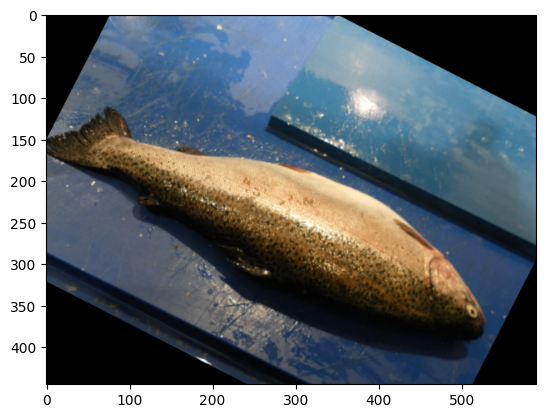

In [5]:
# visualize images from the trainset

print("Number of images:", len(trainset))
image, target = trainset[100] # it executes getitem
image     = image.permute(1,2,0).numpy()
image     = 255*(image - np.min(image))/(np.max(image)-np.min(image))
image     = image.astype('uint8')
print("Images are {}x{}x{}".format(width,height,nchannels))
plt.imshow(image)
print("Class of the image: ", target+1)
plt.show()

In [6]:
batchsize = 3
trainload = DataLoader(trainset, batch_size=batchsize, shuffle=True)
testload  = DataLoader(testset, batch_size=batchsize, shuffle=True)
validload = DataLoader(validset, batch_size=batchsize, shuffle=True)

inspect(next(iter(trainload))) # inspect a couple of items in the batches

══════════════════════════════════════════════════════════════════

list of 2 items

Tensor  Shape: torch.Size([3, 3, 445, 590])     Min: 0.000      Max: 255.000    Mean: 98.030    dtype: 
torch.float32 @ cpu

Tensor  Shape: torch.Size([3])  Min: -1.000     Max: 5.000      Mean: 2.000     dtype: torch.int64 @ cpu

══════════════════════════════════════════════════════════════════

In [15]:
def Criterion(preds, targets):
    ce            = nn.CrossEntropyLoss().to(device)
    loss          = ce(preds, targets.long()) 
    # compute mean accuracy in the batch
    pred_labels   = torch.max(preds, 1)[1] # same as argmax
    acc           = torch.sum(pred_labels == targets.data) / pred_labels.size(0)
    return loss, acc

def conv_block(nchannels_in, nchannels_out, stride_val):
    return nn.Sequential(
        #defining convolutional layer 
        nn.Conv2d(in_channels=nchannels_in, out_channels=nchannels_out, kernel_size=(3, 3),
                  stride=1, padding=1, bias=False),
        #defining a batch normalization layer
        nn.BatchNorm2d(num_features=nchannels_out),
        #defining activation layer
        nn.ReLU(),
        #defining a pooling layer
        nn.MaxPool2d(kernel_size=(3, 3), stride=stride_val, padding=1)
    )

class FishNet(nn.Module):

    def __init__(self, num_classes):
        super(FishNet, self).__init__()
        
        #define the first conv_block
        self.conv1 = conv_block(3,16,1)
        
        #defining the second conv_block
        self.conv2 = conv_block(16,64,2)                      
        
        #defining classifier
        self.classifier = nn.Sequential(
            #defining linear layer
            nn.Linear(in_features=int((width*height*(16+64))/(2*2)), out_features=512, bias=True),
            #defining activation layer
            nn.ReLU(),
            # defining a dropout layer
            nn.Dropout(0.2),
            #defining linear layer as decision layer
            nn.Linear(512, num_classes) #Note that you do not need nn.Softmax in torch
        )

    def forward(self, x):
        #extracts features
        x      = self.conv1(x)
        x      = self.conv2(x)
        #resizes x1 to have the same size of x2. See other operations in functional.
        x      = torch.nn.functional.interpolate(x, scale_factor=(0.5, 0.5), mode='nearest',
                                                  recompute_scale_factor=True)
        #transforms outputs into a 2D tensor
        x = torch.flatten(x, start_dim=1)

        #classifies features
        y = self.classifier(x)
  
        return y

In [16]:
model = FishNet(nclasses).to(device)
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
criterion = Criterion
lr_scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=25, gamma=0.1)

In [17]:
def train_batch(model, data, optimizer, criterion, device):
    model.train()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(preds, targets)
    loss.backward()
    optimizer.step()
    optimizer.zero_grad()

    return loss.item(), acc.item()

@torch.no_grad()
def validate_batch(model, data, criterion, device):
    model.eval()
    ims, targets = data
    ims     = ims.to(device=device)
    targets = targets.to(device=device)
    preds   = model(ims)
    loss, acc = criterion(preds, targets)
    return loss.item(), acc.item()       

In [18]:
# initializing variables
n_epochs = 10
log      = Report(n_epochs)

# starting training and validation
for ex in range(n_epochs):
    N = len(trainload)
    for bx, data in enumerate(trainload):
        loss, acc = train_batch(model, data, optimizer, criterion, device)
        #report results for the batch
        log.record((ex+(bx+1)/N), trn_loss=loss, trn_acc=acc, end='\r')

    N = len(validload)
    for bx, data in enumerate(validload):
        loss, acc = validate_batch(model, data, criterion, device)
        log.record((ex+(bx+1)/N), val_loss=loss, val_acc=acc, end='\r')

    if (ex+1)%2==0: log.report_avgs(ex+1)

RuntimeError: mat1 and mat2 shapes cannot be multiplied (3x1044288 and 4361000x512)

In [ ]:
log.plot_epochs(['trn_loss','val_loss'])
log.plot_epochs(['trn_acc','val_acc'])